Prepare and analyze the cosine similarity results

In [78]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import save_npz, load_npz
import matplotlib.pyplot as plt

In [79]:
# What to do with this? Generate examples for all!

# Look at examples, what is our cos sim threshold?
# Remove where both are -1? and both are 0?
# Which codes appear most often?
# Which codes appear most often when agreement?
# Which codes appear most often in disagreement?
# Look at sentences that are exactly the same: how often is there disagreement?
# What changes if we limit to combinations by different coders/from different documents?
# in 0/-1 codes: how often do coders agree, that there is no meaning in this?

In [80]:
# Set display options to show full contents of each column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# reverse with:
# pd.reset_option('display.max_colwidth')

In [81]:
# load the sparse matrix with the extreme similarity values:
cs_sparse = load_npz('data/cos_sim_output_08_mpnet.npz')

# also load the full corpus df, so that we can add create a df with q_sentences, information and their similarity score for extreme values
corpus_df_full = pd.read_csv("data/english_annotated_full_df.csv")

In [82]:
cs_sparse

<202187x202187 sparse matrix of type '<class 'numpy.float32'>'
	with 379546 stored elements in Compressed Sparse Row format>

In [83]:
# convert the sparse matrix into a useful df:
cs_sparse = coo_matrix(cs_sparse)
data = {
    'index_x': cs_sparse.row,
    'index_y': cs_sparse.col,
    'cosine_similarity': cs_sparse.data
}
cosine_sim_df = pd.DataFrame(data)

In [84]:
cosine_sim_df.head(2)

,index_x,index_y,cosine_similarity
0,7,9,0.851987
1,7,119,0.903366


In [85]:
cosine_sim_df.shape

(379546, 3)

In [86]:
corpus_df = corpus_df_full[['q_sentence', "q_sentence_nr", 'main_codes', 'coderid', 'manifesto_id', 'party', 'date',
        'title', 'countryname', 'partyname', 'RILE']]

In [87]:
# append the columns from the corpus_df, so that we get the info for both quasi sentences
cosine_sim_df = pd.merge(cosine_sim_df, corpus_df, left_on='index_x', right_index=True, how='left')
cosine_sim_df = pd.merge(cosine_sim_df, corpus_df, left_on='index_y', right_index=True, how='left')

In [88]:
cosine_sim_df.head(3)

,index_x,index_y,cosine_similarity,q_sentence_x,q_sentence_nr_x,main_codes_x,coderid_x,manifesto_id_x,party_x,date_x,title_x,countryname_x,partyname_x,RILE_x,q_sentence_y,q_sentence_nr_y,main_codes_y,coderid_y,manifesto_id_y,party_y,date_y,title_y,countryname_y,partyname_y,RILE_y
0,7,9,0.851987,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Key priorities are to:,10,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0
1,7,119,0.903366,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Our priorities are to:,120,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0
2,7,215,0.903366,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Our priorities are to:,216,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0


In [89]:
# How many values do we have that are below -0.8?
cosine_sim_df[cosine_sim_df["cosine_similarity"] < 0].shape
# --> none of them!

(0, 25)

In [90]:
cosine_sim_df.shape

(379546, 25)

Looking at the lowest cosine similarities. Are they good enough?

In [117]:
# cosine_sim_df.sort_values(by="cosine_similarity",
#                           ascending=True)[["q_sentence_x", "main_codes_x", "q_sentence_y", "main_codes_y", "cosine_similarity"]].head(20)

cosine_sim_df.sort_values(by="cosine_similarity",
                          ascending=True)[["manifesto_id_x", "q_sentence_nr_x", "q_sentence_x", "q_sentence_y", "manifesto_id_y", "q_sentence_nr_y", "cosine_similarity"]].head(5)

,manifesto_id_x,q_sentence_nr_x,q_sentence_x,q_sentence_y,manifesto_id_y,q_sentence_nr_y,cosine_similarity
19423,51110_201505,1067,Give higher priority to the physical healthcare of those with mental health problems.,Prioritising mental healthcare,53951_201602,952,0.800000
233298,63810_201607,51,and generate more local investment.,and stimulate their local economy.,64620_202010,457,0.800000
19646,51110_201505,1349,End exploitative zero-hours contracts.,banning exploitative zero-hours contracts,51320_201505,84,0.800002
248096,63320_201905,3053,Reducing unnecessary regulation.,Cut red tape and improved regulations,64620_201111,5486,0.800003
172041,63110_201008,927,"every Australian has the right to access good quality health care, housing and income support.","Reasonable access to quality, affordable health care and education for all Australians, regardless of their location and personal circumstances.",63810_201008,1193,0.800003


Yes, they look very good! (We could even think about lowering the threshold in the calculation script)

General overview: how often do codes appear? How often in agreement / disagreement?
This is done here before removing certain combinations:

In [47]:
codes = np.union1d(cosine_sim_df["main_codes_x"].unique(), cosine_sim_df["main_codes_y"].unique())
total_counts = dict()
agreement_counts = dict()
disagreement_counts = dict()

for c in codes:
    count = ((cosine_sim_df['main_codes_x'] == c) | (cosine_sim_df['main_codes_y'] == c)).sum()
    total_counts[c] = count
    
    count = ((cosine_sim_df['main_codes_x'] == c) & (cosine_sim_df['main_codes_y'] == c)).sum()
    agreement_counts[c] = count

    count = ((cosine_sim_df['main_codes_x'] != c) ^ (cosine_sim_df['main_codes_y'] != c)).sum()
    disagreement_counts[c] = count

# Create a dictionary with the percentage of disagreement for this code
# so disagreement_count/total_count
perc_dict = dict()
for k,v in total_counts.items():
    perc_dict[k] = disagreement_counts[k]/v

# Getting the dicts into a df:

merged_df = pd.merge(pd.DataFrame(list(total_counts.items()), columns=['code', 'total_counts']),
                     pd.DataFrame(list(perc_dict.items()), columns=['code', 'perc_disagree']),
                     on='code')

merged_df_temp = pd.merge(pd.DataFrame(list(agreement_counts.items()), columns=['code', 'agreement_counts']),
                     pd.DataFrame(list(disagreement_counts.items()), columns=['code', 'disagreement_counts']),
                     on='code')

code_combinations_df_full = pd.merge(merged_df, merged_df_temp, on='code')

# add the percentage how often a code appears in the similar sentence combinations:
code_combinations_df_full["perc_total_occurance"] = code_combinations_df_full["total_counts"]/cosine_sim_df.shape[0]

code_combinations_df_full.sort_values(by="perc_total_occurance", ascending=False, inplace=True)
code_combinations_df_full.head(3)

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,perc_total_occurance
0,-1,177147,0.266355,129963,47184,0.466734
1,0,133534,0.343186,87707,45827,0.351826
40,504,19339,0.418015,11255,8084,0.050953


Text(0.5, 1.0, 'Percentage of combinations that contain this code (top 10)')

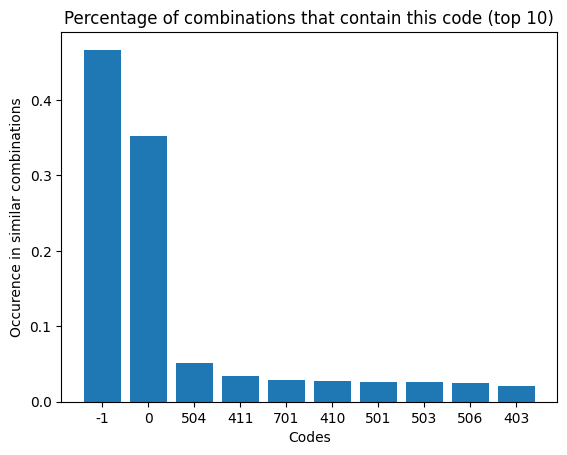

In [119]:
# Plot the most occuring codes:
top_ten_codes = code_combinations_df_full.head(10)["code"].astype(str)
top_ten_percentages = code_combinations_df_full.head(10)["perc_total_occurance"]

plt.bar(top_ten_codes, top_ten_percentages)

plt.xlabel('Codes')
plt.ylabel('Occurence in similar combinations')
plt.title('Percentage of combinations that contain this code (top 10)')

In [118]:
# How often do coders agree that similar sentences have no content/useful meaning? So how often do both give 0 or -1? How often does only one give 0 or -1?

# How often does either -1 or 0 appear in one or both of the codes:
count_a = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) | (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# How often do both codes have either -1 or 0:
count_b = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) & (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# How often does only one code have either -1 or 0:
count_c = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) ^ (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# So, how often do coders disagree on these?
print(count_c/count_a)

0.09033440319222762


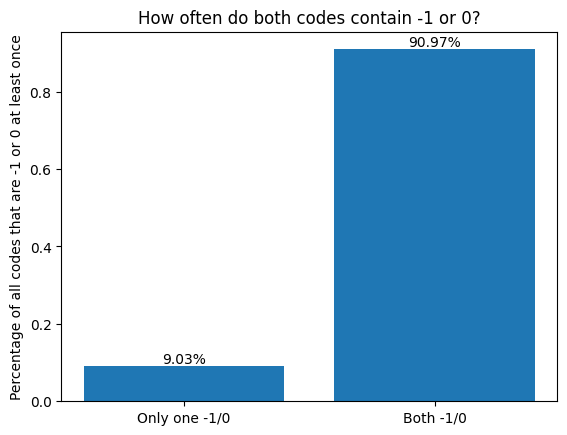

In [125]:
x = ["Only one -1/0", "Both -1/0"]
y = [count_c/count_a, 1-count_c/count_a]

plt.bar(x, y)

plt.ylabel('Percentage of all codes that are -1 or 0 at least once')
plt.title('How often do both codes contain -1 or 0?')

# Annotate the bars with their corresponding values
for i in range(len(x)):
    plt.text(i, y[i], f'{y[i]*100:.2f}%', ha='center', va='bottom')

plt.show()

--> In about 91% of the time, coders agree if there is no meaning in a q_sentence. 9% of the time, one of them sees a meaning!

Removing rows where coders agree on -1 or 0 (so that this q_sentence has no "meaning" per se):

This removes 251.679 combinations, or 66.3% of all combinations

In [14]:
# Remove all rows where both codes are -1; here the coders agree that it is not a topic that needs to be coded, likely just formating etc.
#cosine_sim_df = cosine_sim_df[(cosine_sim_df['main_codes_x'] != -1) | (cosine_sim_df['main_codes_y'] != -1)]
# same thing for both codes 0
#cosine_sim_df = cosine_sim_df[(cosine_sim_df['main_codes_x'] != 0) | (cosine_sim_df['main_codes_y'] != 0)]


# and now also where one is -1 and one is 0: the coders agree, there is no meaning in this

# This does it all in one: removes all rows where both codes are either 0 or -1:
cosine_sim_df = cosine_sim_df[~(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) & (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))]


cosine_sim_df.shape

(127867, 23)

How often do coders disagree on these similar sentences?

In [17]:
# add a column that indicates if coders agreed
cosine_sim_df["in_agreement"] = cosine_sim_df['main_codes_x'] == cosine_sim_df['main_codes_y']

In [18]:
# How often are codes not equal?
1 - sum(cosine_sim_df["in_agreement"])/cosine_sim_df.shape[0]

0.4453690162434405

In [31]:
cosine_sim_df[cosine_sim_df["cosine_similarity"] > 0.975][["q_sentence_x", "main_codes_x", "q_sentence_y", "main_codes_y"]].head(20)

,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y
22,- Give children the best start by providing high quality early years education for every 3 and 4 year-old child whose parents want it.,706,- Give children the best start by providing high quality early years education for every 3 and 4 year-old child whose parents want it.,706
44,- Increase funding for books and equipment in schools.,506,- Increase funding for books and equipment in schools.,506
45,"In the first year, we will double spending on books and equipment to overcome the effect of recent cuts.",-1,"In the first year, we will double spending on books and equipment to overcome the effect of recent cuts.",506
48,- Boost chances for all adults to improve their skills and get better qualifications.,506,- Boost chances for all adults to improve their skills and get better qualifications.,411
191,We will:,-1,We will:,703
493,We will:,-1,We will:,703
808,We will:,-1,We will:,703
1107,We will:,-1,We will:,703
1420,We will:,-1,We will:,703
1764,We will:,-1,We will:,703


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_6024\765672073.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_6024\765672073.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


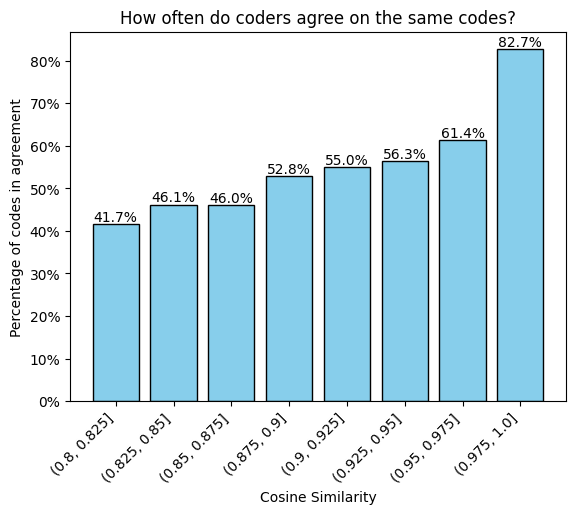

In [19]:
# Define the bins for column A
plot_df = cosine_sim_df.copy()

bins = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0]

# Create a new column 'Bin' which indicates the bin that each value in column A falls into
plot_df['Bin'] = pd.cut(plot_df['cosine_similarity'], bins)

# Calculate the percentage of True values in each bin
bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100

# Create a bar plot
bars = plt.bar(bin_percentages.index.astype(str), bin_percentages, color='skyblue', edgecolor='black')

# Add percentage labels above the bars
for bar, percentage in zip(bars, bin_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Percentage of codes in agreement')
plt.title('How often do coders agree on the same codes?')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# Add '%' sign to the y-axis labels
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

plt.show()

In [20]:
plot_df = cosine_sim_df.copy()
plot_df = plot_df[cosine_sim_df["manifesto_id_x"] != cosine_sim_df["manifesto_id_y"]]

(92738, 24)


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_6024\2374201835.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_6024\2374201835.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


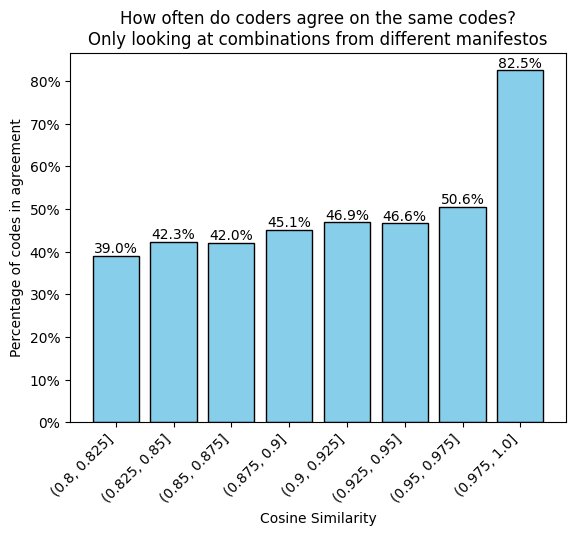

In [21]:
# How does this change if we only take combinations of different documents?
# (So coders dont just pick the same code for the sentence they see again and again?)

# Define the bins for column A
plot_df = cosine_sim_df.copy()
# remove combinations from the same document:
plot_df = plot_df[cosine_sim_df["manifesto_id_x"] != cosine_sim_df["manifesto_id_y"]]
print(plot_df.shape)

bins = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0]

# Create a new column 'Bin' which indicates the bin that each value in column A falls into
plot_df['Bin'] = pd.cut(plot_df['cosine_similarity'], bins)

# Calculate the percentage of True values in each bin
bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100

# Create a bar plot
bars = plt.bar(bin_percentages.index.astype(str), bin_percentages, color='skyblue', edgecolor='black')

# Add percentage labels above the bars
for bar, percentage in zip(bars, bin_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Percentage of codes in agreement')
plt.title('How often do coders agree on the same codes?\nOnly looking at combinations from different manifestos')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# Add '%' sign to the y-axis labels
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

plt.show()

Which codes appear most often? Which most often in agreement? Which most often when not in agreement?

In [22]:
codes = np.union1d(cosine_sim_df["main_codes_x"].unique(), cosine_sim_df["main_codes_y"].unique())

In [23]:
total_counts = dict()
agreement_counts = dict()
disagreement_counts = dict()
for c in codes:
    count = ((cosine_sim_df['main_codes_x'] == c) | (cosine_sim_df['main_codes_y'] == c)).sum()
    total_counts[c] = count
    
    count = ((cosine_sim_df['main_codes_x'] == c) & (cosine_sim_df['main_codes_y'] == c)).sum()
    agreement_counts[c] = count

    count = ((cosine_sim_df['main_codes_x'] != c) ^ (cosine_sim_df['main_codes_y'] != c)).sum()
    disagreement_counts[c] = count


In [24]:
# Create a dictionary with the percentage of disagreement for this code
# so disagreement_count/total_count

perc_dict = dict()
for k,v in total_counts.items():
    perc_dict[k] = disagreement_counts[k]/v

In [25]:
# Getting the dicts into a df:

merged_df = pd.merge(pd.DataFrame(list(total_counts.items()), columns=['code', 'total_counts']),
                     pd.DataFrame(list(perc_dict.items()), columns=['code', 'perc_disagree']),
                     on='code')

merged_df_temp = pd.merge(pd.DataFrame(list(agreement_counts.items()), columns=['code', 'agreement_counts']),
                     pd.DataFrame(list(disagreement_counts.items()), columns=['code', 'disagreement_counts']),
                     on='code')

code_combinations_df = pd.merge(merged_df, merged_df_temp, on='code')

# add the percentage how often a code appears in the similar sentence combinations:
code_combinations_df["perc_total_occurance"] = code_combinations_df["total_counts"]/cosine_sim_df.shape[0]

code_combinations_df.head(3)

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,perc_total_occurance
0,-1,13175,1.000000,0,13175,0.103037
1,0,11818,1.000000,0,11818,0.092424
2,101,748,0.763369,177,571,0.005850


Deeper look into sentences that are exactly the same:

In [26]:
same_df = cosine_sim_df[cosine_sim_df["cosine_similarity"] > 0.9999]
same_df.shape

(29248, 24)

In [27]:
same_df[["q_sentence_x", "main_codes_x", "q_sentence_y", "main_codes_y", "cosine_similarity"]].sort_values(by="cosine_similarity", ascending=True)

,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y,cosine_similarity
221733,$80 million to build the North Lake Bridge.,411,$80 million to build the North Lake Bridge.,411,1.0
185820,He has dedicated his life to public service – to serving his country and the Australian people,305,He has dedicated his life to public service – to serving his country and the Australian people,305,1.0
217705,"A Shorten Labor Government will renew investment in Australian multiculturalism, with $28.3 million of new funding to support social cohesion and economic inclusion.",0,"A Shorten Labor Government will renew investment in Australian multiculturalism, with $28.3 million of new funding to support social cohesion and economic inclusion.",607,1.0
322385,• $30.4 million of P was seized in 2010.,605,• $30.4 million of P was seized in 2010.,605,1.0
185821,He has dedicated his life to public service – to serving his country and the Australian people,305,He has dedicated his life to public service – to serving his country and the Australian people,305,1.0
...,...,...,...,...,...
293813,and improved safety features and standards.,501,and improved safety features and standards.,501,1.0
278249,Securing residential care or Home Care Packages,607,Securing residential care or Home Care Packages,607,1.0
293814,and improved safety features and standards.,501,and improved safety features and standards.,501,1.0
261857,"having completed Commonwealth environment approvals required to start the Adani Carmichael project, with conditions to ensure protection of the environment.",501,"having completed Commonwealth environment approvals required to start the Adani Carmichael project, with conditions to ensure protection of the environment.",501,1.0
